Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6958 │ Recall@10: 0.1665 │ NDCG@10: 0.0895


Epoch 2:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6844 │ Recall@10: 0.2710 │ NDCG@10: 0.1856


Epoch 3:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6688 │ Recall@10: 0.3700 │ NDCG@10: 0.2806


Epoch 4:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6540 │ Recall@10: 0.4240 │ NDCG@10: 0.3280


Epoch 5:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6424 │ Recall@10: 0.4745 │ NDCG@10: 0.3650


Epoch 6:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.6316 │ Recall@10: 0.5150 │ NDCG@10: 0.3952


Epoch 7:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.6220 │ Recall@10: 0.5445 │ NDCG@10: 0.4082


Epoch 8:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.6135 │ Recall@10: 0.5790 │ NDCG@10: 0.4219


Epoch 9:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.6035 │ Recall@10: 0.6000 │ NDCG@10: 0.4292


Epoch 10:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.5909 │ Recall@10: 0.6230 │ NDCG@10: 0.4440


Epoch 11:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.5726 │ Recall@10: 0.6385 │ NDCG@10: 0.4486


Epoch 12:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.5465 │ Recall@10: 0.6430 │ NDCG@10: 0.4423


Epoch 13:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.5051 │ Recall@10: 0.6295 │ NDCG@10: 0.4327


Epoch 14:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.4455 │ Recall@10: 0.6110 │ NDCG@10: 0.4227


Epoch 15:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.3741 │ Recall@10: 0.6085 │ NDCG@10: 0.4165


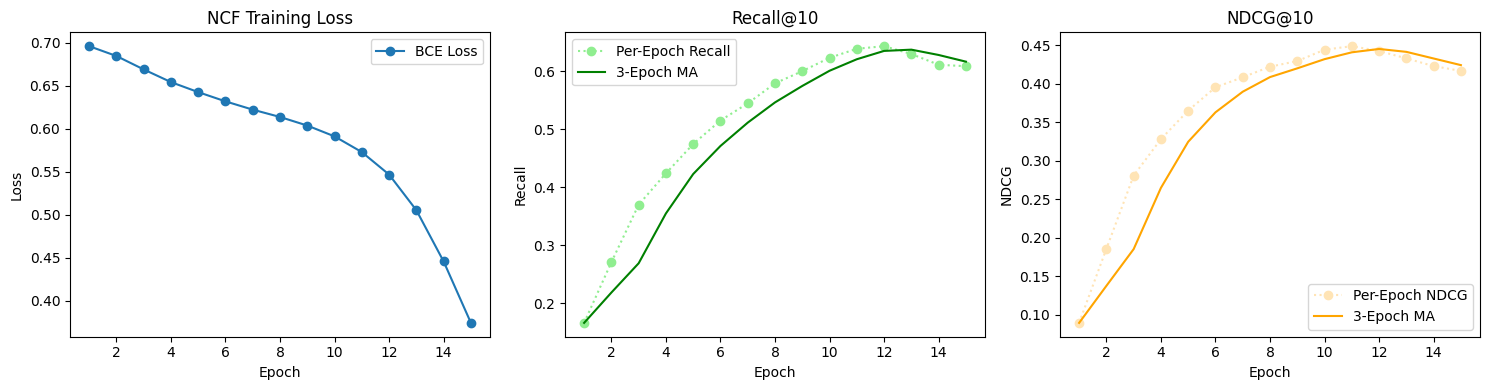

In [1]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 15  # NCF often converges faster than BPR
EMB_DIM = 64  # Start with a reasonable embedding size for NCF
MLP_LAYERS = [EMB_DIM * 2, 256, 128, 64] # Input layer is 2x embedding dim (user+item)
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
except FileNotFoundError:
    print("Error: 'data/Ratings.csv' not found.")
    exit()

ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ NCF Dataset (Pointwise Labels) ───────────────────────────────
class NCFDataset(Dataset):
    def __init__(self, df, n_books, is_training=True):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.is_training = is_training
        if self.is_training:
            self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        
        if self.is_training:
            # For every positive sample, create one negative sample
            item_neg = np.random.randint(self.n_books)
            while (user, item_neg) in self.user_item_set:
                item_neg = np.random.randint(self.n_books)
            
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor([item_pos, item_neg], dtype=torch.long)
            )
        else:
            # For testing, we only need the positive user-item pair
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor(item_pos, dtype=torch.long)
            )

def collate_ncf(batch):
    users, items = zip(*batch)
    # Stack along a new dimension, then reshape
    users = torch.stack(users).repeat_interleave(2) # [u1, u1, u2, u2, ...]
    items = torch.stack(items).flatten() # [i1_pos, i1_neg, i2_pos, i2_neg, ...]
    # Create labels: 1 for positive, 0 for negative
    labels = torch.tensor([1, 0] * (len(batch)), dtype=torch.float32)
    return users, items, labels


train_ds = NCFDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf, num_workers=0)


# ─── 6 │ NCF Model Definition ─────────────────────────────────────────
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, mlp_layers):
        super().__init__()
        # GMF Path
        self.gmf_user_embedding = nn.Embedding(n_users, emb_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, emb_dim)

        # MLP Path
        self.mlp_user_embedding = nn.Embedding(n_users, emb_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, emb_dim)
        
        mlp_modules = []
        for i in range(len(mlp_layers) - 1):
            mlp_modules.append(nn.Linear(mlp_layers[i], mlp_layers[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)

        # Prediction Layer
        # Input size is emb_dim (from GMF) + last mlp_layer size
        predict_size = emb_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item):
        # GMF Path
        gmf_user_emb = self.gmf_user_embedding(user)
        gmf_item_emb = self.gmf_item_embedding(item)
        gmf_vector = gmf_user_emb * gmf_item_emb

        # MLP Path
        mlp_user_emb = self.mlp_user_embedding(user)
        mlp_item_emb = self.mlp_item_embedding(item)
        mlp_input = torch.cat([mlp_user_emb, mlp_item_emb], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        # Concatenate GMF and MLP paths
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        
        # Final prediction
        prediction = self.predict_layer(final_vector)
        return prediction.squeeze()

model = NCF(n_users, n_books, EMB_DIM, MLP_LAYERS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss() # Use Binary Cross-Entropy for NCF

# ─── 7 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            scores = model(u_tensor, eval_b_indices).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, labels = users.to(DEVICE), items.to(DEVICE), labels.to(DEVICE)
        
        opt.zero_grad()
        predictions = model(users, items)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BCE Loss')
plt.title("NCF Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

# Recall@10
plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

# NDCG@10
plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6984 │ Recall@10: 0.1995 │ NDCG@10: 0.1052


Epoch 2:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6813 │ Recall@10: 0.3055 │ NDCG@10: 0.2229


Epoch 3:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6646 │ Recall@10: 0.3885 │ NDCG@10: 0.2931


Epoch 4:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6516 │ Recall@10: 0.4445 │ NDCG@10: 0.3442


Epoch 5:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6415 │ Recall@10: 0.4805 │ NDCG@10: 0.3689


Epoch 6:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.6323 │ Recall@10: 0.5195 │ NDCG@10: 0.3938


Epoch 7:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.6243 │ Recall@10: 0.5560 │ NDCG@10: 0.4086


Epoch 8:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.6168 │ Recall@10: 0.5780 │ NDCG@10: 0.4227


Epoch 9:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.6077 │ Recall@10: 0.6115 │ NDCG@10: 0.4375


Epoch 10:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.5978 │ Recall@10: 0.6160 │ NDCG@10: 0.4449


Epoch 11:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.5842 │ Recall@10: 0.6155 │ NDCG@10: 0.4373


Epoch 12:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.5647 │ Recall@10: 0.6285 │ NDCG@10: 0.4436


Epoch 13:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.5350 │ Recall@10: 0.6305 │ NDCG@10: 0.4413


Epoch 14:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.4870 │ Recall@10: 0.6215 │ NDCG@10: 0.4288


Epoch 15:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.4216 │ Recall@10: 0.6210 │ NDCG@10: 0.4322


Epoch 16:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 │ Loss: 0.3533 │ Recall@10: 0.6125 │ NDCG@10: 0.4169


Epoch 17:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 │ Loss: 0.2555 │ Recall@10: 0.6170 │ NDCG@10: 0.4248


Epoch 18:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 │ Loss: 0.2048 │ Recall@10: 0.6115 │ NDCG@10: 0.4184


Epoch 19:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 │ Loss: 0.1766 │ Recall@10: 0.6140 │ NDCG@10: 0.4166


Epoch 20:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 │ Loss: 0.1548 │ Recall@10: 0.6105 │ NDCG@10: 0.4183


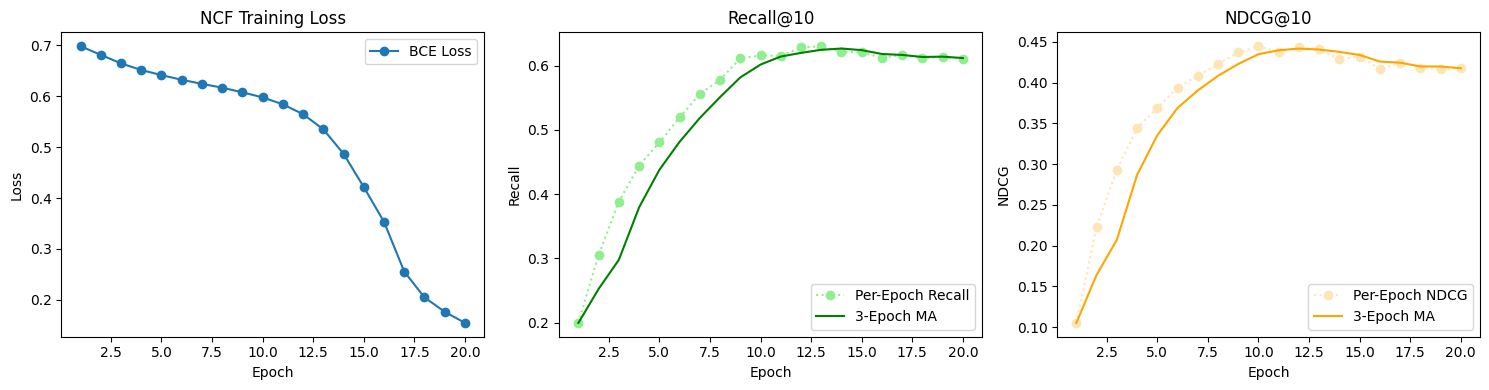

In [3]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 20 # Increased epochs slightly to give scheduler time to work
EMB_DIM = 64
# Deeper MLP Layers: added a 32-neuron layer
MLP_LAYERS = [EMB_DIM * 2, 256, 128, 64, 32] 
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
except FileNotFoundError:
    print("Error: 'data/Ratings.csv' not found.")
    exit()

ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ NCF Dataset (Pointwise Labels) ───────────────────────────────
class NCFDataset(Dataset):
    def __init__(self, df, n_books, is_training=True):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.is_training = is_training
        if self.is_training:
            self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        
        if self.is_training:
            # For every positive sample, create one negative sample
            item_neg = np.random.randint(self.n_books)
            while (user, item_neg) in self.user_item_set:
                item_neg = np.random.randint(self.n_books)
            
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor([item_pos, item_neg], dtype=torch.long)
            )
        else:
            # For testing, we only need the positive user-item pair
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor(item_pos, dtype=torch.long)
            )

def collate_ncf(batch):
    users, items = zip(*batch)
    # Stack along a new dimension, then reshape
    users = torch.stack(users).repeat_interleave(2)
    items = torch.stack(items).flatten()
    # Create labels: 1 for positive, 0 for negative
    labels = torch.tensor([1, 0] * (len(batch)), dtype=torch.float32)
    return users, items, labels

train_ds = NCFDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf, num_workers=0)

# ─── 6 │ NCF Model Definition ─────────────────────────────────────────
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, mlp_layers):
        super().__init__()
        self.gmf_user_embedding = nn.Embedding(n_users, emb_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, emb_dim)
        self.mlp_user_embedding = nn.Embedding(n_users, emb_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, emb_dim)
        
        mlp_modules = []
        for i in range(len(mlp_layers) - 1):
            mlp_modules.append(nn.Linear(mlp_layers[i], mlp_layers[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)

        predict_size = emb_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item):
        gmf_user_emb = self.gmf_user_embedding(user)
        gmf_item_emb = self.gmf_item_embedding(item)
        gmf_vector = gmf_user_emb * gmf_item_emb

        mlp_user_emb = self.mlp_user_embedding(user)
        mlp_item_emb = self.mlp_item_embedding(item)
        mlp_input = torch.cat([mlp_user_emb, mlp_item_emb], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        prediction = self.predict_layer(final_vector)
        return prediction.squeeze()

model = NCF(n_users, n_books, EMB_DIM, MLP_LAYERS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

# Add the learning rate scheduler
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=2)

# ─── 7 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            scores = model(u_tensor, eval_b_indices).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, labels = users.to(DEVICE), items.to(DEVICE), labels.to(DEVICE)
        
        opt.zero_grad()
        predictions = model(users, items)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")
    
    # Step the scheduler based on the validation recall
    scheduler.step(recall)

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BCE Loss')
plt.title("NCF Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6944 │ Recall@10: 0.1660 │ NDCG@10: 0.0897


Epoch 2:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6764 │ Recall@10: 0.2645 │ NDCG@10: 0.1813


Epoch 3:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6517 │ Recall@10: 0.3375 │ NDCG@10: 0.2418


Epoch 4:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6278 │ Recall@10: 0.3940 │ NDCG@10: 0.2988


Epoch 5:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6043 │ Recall@10: 0.4295 │ NDCG@10: 0.3344


Epoch 6:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.5812 │ Recall@10: 0.4680 │ NDCG@10: 0.3678


Epoch 7:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.5550 │ Recall@10: 0.5080 │ NDCG@10: 0.4000


Epoch 8:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.5254 │ Recall@10: 0.5495 │ NDCG@10: 0.4313


Epoch 9:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.4898 │ Recall@10: 0.5875 │ NDCG@10: 0.4586


Epoch 10:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.4497 │ Recall@10: 0.6150 │ NDCG@10: 0.4840


Epoch 11:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.4060 │ Recall@10: 0.6550 │ NDCG@10: 0.5069


Epoch 12:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.3566 │ Recall@10: 0.6780 │ NDCG@10: 0.5318


Epoch 13:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.3073 │ Recall@10: 0.6955 │ NDCG@10: 0.5421


Epoch 14:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.2598 │ Recall@10: 0.7160 │ NDCG@10: 0.5509


Epoch 15:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.2216 │ Recall@10: 0.7300 │ NDCG@10: 0.5617


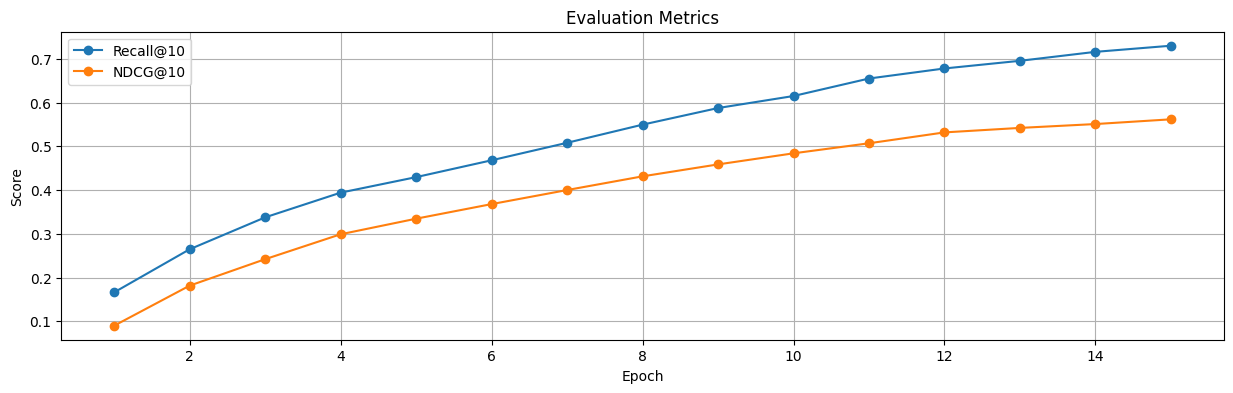

In [1]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 15
# Embedding dimensions for new features
AGE_EMB_DIM = 16
CLUSTER_EMB_DIM = 16
# Base embedding dimension for users and items
BASE_EMB_DIM = 64 
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Preprocess Data ───────────────────────────────────────
# Load all datasets
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
    users_df = pd.read_csv("data/Users.csv")
    books_meta_df = pd.read_csv("clustered_outputs/clustered_books_metadata.csv")[['ISBN', 'genre_cluster']]
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    exit()

# Handle User Age: Fill NaN with median and convert to int
median_age = users_df['Age'].median()
users_df['Age'] = users_df['Age'].fillna(median_age).astype(int)

# Merge the datasets into one
df = pd.merge(ratings_raw, users_df, on='User-ID')
df = pd.merge(df, books_meta_df, on='ISBN')
df = df[df["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
train_df = df[df['rank_latest'] != 1]
test_df = df[df['rank_latest'] == 1]
train_df, test_df = train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

# ─── 4 │ Encode IDs and Features ──────────────────────────────────────
user2idx = {u: i for i, u in enumerate(df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(df["ISBN"].unique())}
age2idx = {a: i for i, a in enumerate(df["Age"].unique())}
cluster2idx = {c: i for i, c in enumerate(df["genre_cluster"].unique())}

# Apply mappings to all dataframes
for df_slice in [train_df, test_df]:
    df_slice["user_idx"] = df_slice["User-ID"].map(user2idx)
    df_slice["book_idx"] = df_slice["ISBN"].map(book2idx)
    df_slice["age_idx"] = df_slice["Age"].map(age2idx)
    df_slice["cluster_idx"] = df_slice["genre_cluster"].map(cluster2idx)

test_df = test_df.dropna().astype({col: int for col in ['user_idx', 'book_idx', 'age_idx', 'cluster_idx']})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users = len(user2idx)
n_books = len(book2idx)
n_ages = len(age2idx)
n_clusters = len(cluster2idx)

# Define MLP input layer size based on all features
MLP_INPUT_DIM = (BASE_EMB_DIM * 2) + AGE_EMB_DIM + CLUSTER_EMB_DIM
MLP_LAYERS = [MLP_INPUT_DIM, 256, 128, 64]

# ─── 5 │ Dataset with Features ────────────────────────────────────────
class NCFDatasetWithFeatures(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.ages = df["age_idx"].values
        self.clusters = df["cluster_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user, item_pos, age, cluster = self.users[idx], self.items[idx], self.ages[idx], self.clusters[idx]
        item_neg = np.random.randint(self.n_books)
        while (user, item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
        return user, item_pos, item_neg, age, cluster

def collate_ncf_features(batch):
    users, items_pos, items_neg, ages, clusters = zip(*batch)
    
    users = torch.tensor(users, dtype=torch.long).repeat_interleave(2)
    ages = torch.tensor(ages, dtype=torch.long).repeat_interleave(2)
    clusters = torch.tensor(clusters, dtype=torch.long).repeat_interleave(2)
    
    items = torch.stack([torch.tensor(items_pos, dtype=torch.long), torch.tensor(items_neg, dtype=torch.long)], dim=1).flatten()
    labels = torch.tensor([1, 0] * len(batch), dtype=torch.float32)
    
    return users, items, ages, clusters, labels

train_ds = NCFDatasetWithFeatures(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf_features, num_workers=0)

# ─── 6 │ Hybrid NCF Model Definition ──────────────────────────────────
class HybridNCF(nn.Module):
    def __init__(self):
        super().__init__()
        # Embeddings for GMF path
        self.gmf_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.gmf_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        
        # Embeddings for MLP path
        self.mlp_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.mlp_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        self.mlp_age_emb = nn.Embedding(n_ages, AGE_EMB_DIM)
        self.mlp_cluster_emb = nn.Embedding(n_clusters, CLUSTER_EMB_DIM)
        
        mlp_modules = []
        for i in range(len(MLP_LAYERS) - 1):
            mlp_modules.append(nn.Linear(MLP_LAYERS[i], MLP_LAYERS[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)
        
        predict_size = BASE_EMB_DIM + MLP_LAYERS[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item, age, cluster):
        # GMF Path (only user-item interaction)
        gmf_vector = self.gmf_user_emb(user) * self.gmf_item_emb(item)
        
        # MLP Path (user, item, and their features)
        mlp_user_vec = self.mlp_user_emb(user)
        mlp_item_vec = self.mlp_item_emb(item)
        mlp_age_vec = self.mlp_age_emb(age)
        mlp_cluster_vec = self.mlp_cluster_emb(cluster)
        
        mlp_input = torch.cat([mlp_user_vec, mlp_item_vec, mlp_age_vec, mlp_cluster_vec], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        return self.predict_layer(final_vector).squeeze()

model = HybridNCF().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

# ─── 7 │ Evaluation Function (Updated for Features) ───────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            age_idx, cluster_idx = int(row["age_idx"]), int(row["cluster_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            age_tensor = torch.tensor([age_idx] * len(eval_b_indices), device=DEVICE)
            # For evaluation, we assume the cluster of negative items is unknown or irrelevant, 
            # so we use the positive item's cluster for all. This is a common simplification.
            cluster_tensor = torch.tensor([cluster_idx] * len(eval_b_indices), device=DEVICE)

            scores = model(u_tensor, eval_b_indices, age_tensor, cluster_tensor).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, ages, clusters, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, ages, clusters, labels = (t.to(DEVICE) for t in [users, items, ages, clusters, labels])
        
        opt.zero_grad()
        predictions = model(users, items, ages, clusters)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)
plt.plot(epochs_range, recall_hist, marker='o', label='Recall@10')
plt.plot(epochs_range, ndcg_hist, marker='o', label='NDCG@10')
plt.title("Evaluation Metrics")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.show()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6942 │ Recall@10: 0.1890 │ NDCG@10: 0.1133


Epoch 2:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6654 │ Recall@10: 0.3155 │ NDCG@10: 0.2153


Epoch 3:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6332 │ Recall@10: 0.3820 │ NDCG@10: 0.2828


Epoch 4:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6052 │ Recall@10: 0.4290 │ NDCG@10: 0.3331


Epoch 5:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.5794 │ Recall@10: 0.4740 │ NDCG@10: 0.3801


Epoch 6:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.5528 │ Recall@10: 0.5045 │ NDCG@10: 0.4119


Epoch 7:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.5246 │ Recall@10: 0.5420 │ NDCG@10: 0.4461


Epoch 8:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.4929 │ Recall@10: 0.5770 │ NDCG@10: 0.4805


Epoch 9:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.4573 │ Recall@10: 0.6070 │ NDCG@10: 0.5114


Epoch 10:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.4172 │ Recall@10: 0.6405 │ NDCG@10: 0.5396


Epoch 11:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.3722 │ Recall@10: 0.6755 │ NDCG@10: 0.5705


Epoch 12:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.3224 │ Recall@10: 0.7075 │ NDCG@10: 0.6055


Epoch 13:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.2698 │ Recall@10: 0.7370 │ NDCG@10: 0.6395


Epoch 14:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.2202 │ Recall@10: 0.7555 │ NDCG@10: 0.6583


Epoch 15:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.1751 │ Recall@10: 0.7655 │ NDCG@10: 0.6719


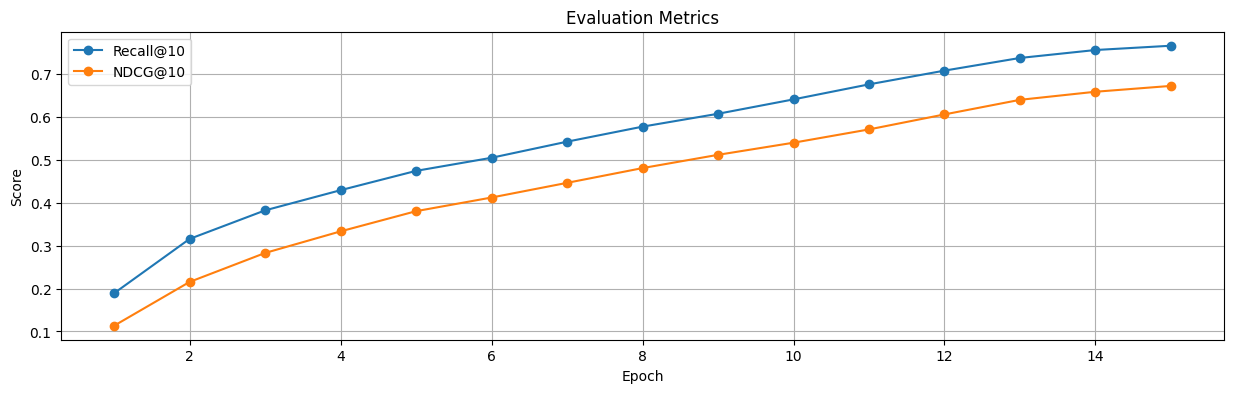

In [1]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 15
# Embedding dimensions for all features
BASE_EMB_DIM = 64
AGE_EMB_DIM = 16
GENRE_CLUSTER_EMB_DIM = 16
TONE_CLUSTER_EMB_DIM = 16
AUDIENCE_CLUSTER_EMB_DIM = 16
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Preprocess Data ───────────────────────────────────────
# Load all datasets
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
    users_df = pd.read_csv("data/Users.csv")
    # Use the clustered versions for tone and audience
    books_meta_df = pd.read_csv("clustered_outputs/clustered_books_metadata.csv")[['ISBN', 'genre_cluster', 'tone_cluster', 'audience_cluster']]
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    exit()

# Handle User Age
median_age = users_df['Age'].median()
users_df['Age'] = users_df['Age'].fillna(median_age).astype(int)

# Merge the datasets
df = pd.merge(ratings_raw, users_df, on='User-ID')
df = pd.merge(df, books_meta_df, on='ISBN')
df = df[df["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
train_df = df[df['rank_latest'] != 1]
test_df = df[df['rank_latest'] == 1]
train_df, test_df = train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

# ─── 4 │ Encode IDs and Features ──────────────────────────────────────
# Create mappings for all categorical features
user2idx = {u: i for i, u in enumerate(df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(df["ISBN"].unique())}
age2idx = {a: i for i, a in enumerate(df["Age"].unique())}
genre_cluster2idx = {c: i for i, c in enumerate(df["genre_cluster"].unique())}
tone_cluster2idx = {t: i for i, t in enumerate(df["tone_cluster"].unique())}
audience_cluster2idx = {a: i for i, a in enumerate(df["audience_cluster"].unique())}

# Apply mappings
for df_slice in [train_df, test_df]:
    df_slice["user_idx"] = df_slice["User-ID"].map(user2idx)
    df_slice["book_idx"] = df_slice["ISBN"].map(book2idx)
    df_slice["age_idx"] = df_slice["Age"].map(age2idx)
    df_slice["genre_cluster_idx"] = df_slice["genre_cluster"].map(genre_cluster2idx)
    df_slice["tone_cluster_idx"] = df_slice["tone_cluster"].map(tone_cluster2idx)
    df_slice["audience_cluster_idx"] = df_slice["audience_cluster"].map(audience_cluster2idx)

feature_cols = ['user_idx', 'book_idx', 'age_idx', 'genre_cluster_idx', 'tone_cluster_idx', 'audience_cluster_idx']
test_df = test_df.dropna(subset=feature_cols).astype({col: int for col in feature_cols})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

# Count unique values for embedding layers
n_users = len(user2idx)
n_books = len(book2idx)
n_ages = len(age2idx)
n_genre_clusters = len(genre_cluster2idx)
n_tone_clusters = len(tone_cluster2idx)
n_audience_clusters = len(audience_cluster2idx)

# Define MLP input layer size based on all features
MLP_INPUT_DIM = (BASE_EMB_DIM * 2) + AGE_EMB_DIM + GENRE_CLUSTER_EMB_DIM + TONE_CLUSTER_EMB_DIM + AUDIENCE_CLUSTER_EMB_DIM
MLP_LAYERS = [MLP_INPUT_DIM, 256, 128, 64]

# ─── 5 │ Dataset with Features ────────────────────────────────────────
class NCFDatasetWithFeatures(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.ages = df["age_idx"].values
        self.genre_clusters = df["genre_cluster_idx"].values
        self.tone_clusters = df["tone_cluster_idx"].values
        self.audience_clusters = df["audience_cluster_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user, item_pos = self.users[idx], self.items[idx]
        age, genre_c = self.ages[idx], self.genre_clusters[idx]
        tone_c, audience_c = self.tone_clusters[idx], self.audience_clusters[idx]
        
        item_neg = np.random.randint(self.n_books)
        while (user, item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
        
        return user, item_pos, item_neg, age, genre_c, tone_c, audience_c

def collate_ncf_features(batch):
    users, items_pos, items_neg, ages, genre_cs, tone_cs, audience_cs = zip(*batch)
    
    users = torch.tensor(users, dtype=torch.long).repeat_interleave(2)
    ages = torch.tensor(ages, dtype=torch.long).repeat_interleave(2)
    
    genre_cs = torch.tensor(genre_cs, dtype=torch.long).repeat_interleave(2)
    tone_cs = torch.tensor(tone_cs, dtype=torch.long).repeat_interleave(2)
    audience_cs = torch.tensor(audience_cs, dtype=torch.long).repeat_interleave(2)
    
    items = torch.stack([torch.tensor(items_pos, dtype=torch.long), torch.tensor(items_neg, dtype=torch.long)], dim=1).flatten()
    labels = torch.tensor([1, 0] * len(batch), dtype=torch.float32)
    
    return users, items, ages, genre_cs, tone_cs, audience_cs, labels

train_ds = NCFDatasetWithFeatures(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf_features, num_workers=0)

# ─── 6 │ Hybrid NCF Model Definition ──────────────────────────────────
class HybridNCF(nn.Module):
    def __init__(self):
        super().__init__()
        self.gmf_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.gmf_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        
        self.mlp_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.mlp_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        self.mlp_age_emb = nn.Embedding(n_ages, AGE_EMB_DIM)
        self.mlp_genre_cluster_emb = nn.Embedding(n_genre_clusters, GENRE_CLUSTER_EMB_DIM)
        self.mlp_tone_cluster_emb = nn.Embedding(n_tone_clusters, TONE_CLUSTER_EMB_DIM)
        self.mlp_audience_cluster_emb = nn.Embedding(n_audience_clusters, AUDIENCE_CLUSTER_EMB_DIM)
        
        mlp_modules = []
        for i in range(len(MLP_LAYERS) - 1):
            mlp_modules.append(nn.Linear(MLP_LAYERS[i], MLP_LAYERS[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)
        
        predict_size = BASE_EMB_DIM + MLP_LAYERS[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item, age, genre_c, tone_c, audience_c):
        gmf_vector = self.gmf_user_emb(user) * self.gmf_item_emb(item)
        
        mlp_input = torch.cat([
            self.mlp_user_emb(user),
            self.mlp_item_emb(item),
            self.mlp_age_emb(age),
            self.mlp_genre_cluster_emb(genre_c),
            self.mlp_tone_cluster_emb(tone_c),
            self.mlp_audience_cluster_emb(audience_c)
        ], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        return self.predict_layer(final_vector).squeeze()

model = HybridNCF().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

# ─── 7 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            age_idx, genre_c_idx = int(row["age_idx"]), int(row["genre_cluster_idx"])
            tone_c_idx, audience_c_idx = int(row["tone_cluster_idx"]), int(row["audience_cluster_idx"])

            seen_books = train_history.get(u_idx, set())
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples * 2)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            age_tensor = torch.tensor([age_idx] * len(eval_b_indices), device=DEVICE)
            genre_c_tensor = torch.tensor([genre_c_idx] * len(eval_b_indices), device=DEVICE)
            tone_c_tensor = torch.tensor([tone_c_idx] * len(eval_b_indices), device=DEVICE)
            audience_c_tensor = torch.tensor([audience_c_idx] * len(eval_b_indices), device=DEVICE)

            scores = model(u_tensor, eval_b_indices, age_tensor, genre_c_tensor, tone_c_tensor, audience_c_tensor).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, ages, genre_cs, tone_cs, audience_cs, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        tensors = [users, items, ages, genre_cs, tone_cs, audience_cs, labels]
        users, items, ages, genre_cs, tone_cs, audience_cs, labels = (t.to(DEVICE) for t in tensors)
        
        opt.zero_grad()
        predictions = model(users, items, ages, genre_cs, tone_cs, audience_cs)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)
plt.plot(epochs_range, recall_hist, marker='o', label='Recall@10')
plt.plot(epochs_range, ndcg_hist, marker='o', label='NDCG@10')
plt.title("Evaluation Metrics")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.show()

Loading data for experiment: Ratings Only...


Training 'Ratings Only':   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 | Ratings Only | Recall@10: 0.1550 | NDCG@10: 0.0829


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 | Ratings Only | Recall@10: 0.2300 | NDCG@10: 0.1448


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 | Ratings Only | Recall@10: 0.2715 | NDCG@10: 0.1967


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 | Ratings Only | Recall@10: 0.3185 | NDCG@10: 0.2325


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 | Ratings Only | Recall@10: 0.3520 | NDCG@10: 0.2606


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 | Ratings Only | Recall@10: 0.3820 | NDCG@10: 0.2774


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 | Ratings Only | Recall@10: 0.3900 | NDCG@10: 0.2899


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 | Ratings Only | Recall@10: 0.4160 | NDCG@10: 0.3018


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 | Ratings Only | Recall@10: 0.4265 | NDCG@10: 0.3078


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 | Ratings Only | Recall@10: 0.4345 | NDCG@10: 0.3065


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 | Ratings Only | Recall@10: 0.4415 | NDCG@10: 0.3100


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 | Ratings Only | Recall@10: 0.4450 | NDCG@10: 0.3061


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 | Ratings Only | Recall@10: 0.4360 | NDCG@10: 0.3035


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 | Ratings Only | Recall@10: 0.4275 | NDCG@10: 0.2972


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 | Ratings Only | Recall@10: 0.4240 | NDCG@10: 0.2938


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 | Ratings Only | Recall@10: 0.4290 | NDCG@10: 0.2977


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 | Ratings Only | Recall@10: 0.4360 | NDCG@10: 0.2959


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 | Ratings Only | Recall@10: 0.4285 | NDCG@10: 0.2846


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 | Ratings Only | Recall@10: 0.4395 | NDCG@10: 0.2939


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 | Ratings Only | Recall@10: 0.4415 | NDCG@10: 0.2906


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 21 | Ratings Only | Recall@10: 0.4455 | NDCG@10: 0.2975


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 22 | Ratings Only | Recall@10: 0.4495 | NDCG@10: 0.2976


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 23 | Ratings Only | Recall@10: 0.4455 | NDCG@10: 0.2982


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 24 | Ratings Only | Recall@10: 0.4430 | NDCG@10: 0.2922


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 25 | Ratings Only | Recall@10: 0.4400 | NDCG@10: 0.2936


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 26 | Ratings Only | Recall@10: 0.4420 | NDCG@10: 0.2961


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 27 | Ratings Only | Recall@10: 0.4400 | NDCG@10: 0.2982


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 28 | Ratings Only | Recall@10: 0.4320 | NDCG@10: 0.2893


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 29 | Ratings Only | Recall@10: 0.4320 | NDCG@10: 0.2889


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 30 | Ratings Only | Recall@10: 0.4380 | NDCG@10: 0.3009


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 31 | Ratings Only | Recall@10: 0.4220 | NDCG@10: 0.2885


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 32 | Ratings Only | Recall@10: 0.4210 | NDCG@10: 0.2884


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 33 | Ratings Only | Recall@10: 0.4260 | NDCG@10: 0.2903


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 34 | Ratings Only | Recall@10: 0.4270 | NDCG@10: 0.2918


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 35 | Ratings Only | Recall@10: 0.4305 | NDCG@10: 0.2864


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 36 | Ratings Only | Recall@10: 0.4265 | NDCG@10: 0.2913


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 37 | Ratings Only | Recall@10: 0.4245 | NDCG@10: 0.2922


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 38 | Ratings Only | Recall@10: 0.4195 | NDCG@10: 0.2930


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 39 | Ratings Only | Recall@10: 0.4190 | NDCG@10: 0.2978


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 40 | Ratings Only | Recall@10: 0.4235 | NDCG@10: 0.2978


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 41 | Ratings Only | Recall@10: 0.4270 | NDCG@10: 0.2929


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 42 | Ratings Only | Recall@10: 0.4275 | NDCG@10: 0.2985


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 43 | Ratings Only | Recall@10: 0.4215 | NDCG@10: 0.2957


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 44 | Ratings Only | Recall@10: 0.4155 | NDCG@10: 0.2937


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 45 | Ratings Only | Recall@10: 0.4190 | NDCG@10: 0.2929


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 46 | Ratings Only | Recall@10: 0.4165 | NDCG@10: 0.2924


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 47 | Ratings Only | Recall@10: 0.4145 | NDCG@10: 0.2910


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 48 | Ratings Only | Recall@10: 0.4170 | NDCG@10: 0.2841


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 49 | Ratings Only | Recall@10: 0.4145 | NDCG@10: 0.2958


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 50 | Ratings Only | Recall@10: 0.4050 | NDCG@10: 0.2842
Loading data for experiment: Limited Features...


C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_13344\1830394765.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_df['Age'] = users_df['Age'].fillna(users_df['Age'].median()).astype(int)


Training 'Limited Features':   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 | Limited Features | Recall@10: 0.1805 | NDCG@10: 0.1012


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 | Limited Features | Recall@10: 0.2705 | NDCG@10: 0.1803


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 | Limited Features | Recall@10: 0.3355 | NDCG@10: 0.2484


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 | Limited Features | Recall@10: 0.3710 | NDCG@10: 0.2856


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 | Limited Features | Recall@10: 0.4250 | NDCG@10: 0.3285


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 | Limited Features | Recall@10: 0.4585 | NDCG@10: 0.3622


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 | Limited Features | Recall@10: 0.5080 | NDCG@10: 0.4011


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 | Limited Features | Recall@10: 0.5390 | NDCG@10: 0.4224


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 | Limited Features | Recall@10: 0.5775 | NDCG@10: 0.4521


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 | Limited Features | Recall@10: 0.6250 | NDCG@10: 0.4858


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 | Limited Features | Recall@10: 0.6420 | NDCG@10: 0.5099


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 | Limited Features | Recall@10: 0.6695 | NDCG@10: 0.5232


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 | Limited Features | Recall@10: 0.6930 | NDCG@10: 0.5352


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 | Limited Features | Recall@10: 0.7165 | NDCG@10: 0.5501


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 | Limited Features | Recall@10: 0.7295 | NDCG@10: 0.5565


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 | Limited Features | Recall@10: 0.7325 | NDCG@10: 0.5671


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 | Limited Features | Recall@10: 0.7455 | NDCG@10: 0.5734


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 | Limited Features | Recall@10: 0.7440 | NDCG@10: 0.5832


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 | Limited Features | Recall@10: 0.7545 | NDCG@10: 0.5850


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 | Limited Features | Recall@10: 0.7545 | NDCG@10: 0.5879


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 21 | Limited Features | Recall@10: 0.7550 | NDCG@10: 0.5916


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 22 | Limited Features | Recall@10: 0.7535 | NDCG@10: 0.5970


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 23 | Limited Features | Recall@10: 0.7520 | NDCG@10: 0.5899


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 24 | Limited Features | Recall@10: 0.7575 | NDCG@10: 0.5939


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 25 | Limited Features | Recall@10: 0.7575 | NDCG@10: 0.5925


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 26 | Limited Features | Recall@10: 0.7565 | NDCG@10: 0.5980


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 27 | Limited Features | Recall@10: 0.7570 | NDCG@10: 0.6051


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 28 | Limited Features | Recall@10: 0.7565 | NDCG@10: 0.5979


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 29 | Limited Features | Recall@10: 0.7605 | NDCG@10: 0.6020


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 30 | Limited Features | Recall@10: 0.7565 | NDCG@10: 0.5976


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 31 | Limited Features | Recall@10: 0.7505 | NDCG@10: 0.6001


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 32 | Limited Features | Recall@10: 0.7555 | NDCG@10: 0.6005


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 33 | Limited Features | Recall@10: 0.7510 | NDCG@10: 0.5948


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 34 | Limited Features | Recall@10: 0.7450 | NDCG@10: 0.5978


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 35 | Limited Features | Recall@10: 0.7430 | NDCG@10: 0.5903


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 36 | Limited Features | Recall@10: 0.7450 | NDCG@10: 0.5922


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 37 | Limited Features | Recall@10: 0.7465 | NDCG@10: 0.5956


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 38 | Limited Features | Recall@10: 0.7370 | NDCG@10: 0.5973


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 39 | Limited Features | Recall@10: 0.7465 | NDCG@10: 0.5983


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 40 | Limited Features | Recall@10: 0.7440 | NDCG@10: 0.5936


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 41 | Limited Features | Recall@10: 0.7375 | NDCG@10: 0.5927


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 42 | Limited Features | Recall@10: 0.7415 | NDCG@10: 0.5944


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 43 | Limited Features | Recall@10: 0.7350 | NDCG@10: 0.5839


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 44 | Limited Features | Recall@10: 0.7325 | NDCG@10: 0.5936


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 45 | Limited Features | Recall@10: 0.7305 | NDCG@10: 0.5901


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 46 | Limited Features | Recall@10: 0.7300 | NDCG@10: 0.5928


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 47 | Limited Features | Recall@10: 0.7300 | NDCG@10: 0.5925


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 48 | Limited Features | Recall@10: 0.7245 | NDCG@10: 0.5899


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 49 | Limited Features | Recall@10: 0.7210 | NDCG@10: 0.5809


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 50 | Limited Features | Recall@10: 0.7185 | NDCG@10: 0.5836
Loading data for experiment: Full Features...


C:\Users\a.khajooei\AppData\Local\Temp\ipykernel_13344\1830394765.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_df['Age'] = users_df['Age'].fillna(users_df['Age'].median()).astype(int)


Training 'Full Features':   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 | Full Features | Recall@10: 0.2205 | NDCG@10: 0.1318


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 | Full Features | Recall@10: 0.3060 | NDCG@10: 0.2195


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 | Full Features | Recall@10: 0.3760 | NDCG@10: 0.2836


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 | Full Features | Recall@10: 0.4255 | NDCG@10: 0.3295


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 | Full Features | Recall@10: 0.4730 | NDCG@10: 0.3715


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 | Full Features | Recall@10: 0.5060 | NDCG@10: 0.4142


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 | Full Features | Recall@10: 0.5520 | NDCG@10: 0.4502


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 | Full Features | Recall@10: 0.5890 | NDCG@10: 0.4861


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 | Full Features | Recall@10: 0.6255 | NDCG@10: 0.5221


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 | Full Features | Recall@10: 0.6590 | NDCG@10: 0.5540


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 | Full Features | Recall@10: 0.6860 | NDCG@10: 0.5825


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 | Full Features | Recall@10: 0.7200 | NDCG@10: 0.6149


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 | Full Features | Recall@10: 0.7325 | NDCG@10: 0.6376


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 | Full Features | Recall@10: 0.7485 | NDCG@10: 0.6632


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 | Full Features | Recall@10: 0.7700 | NDCG@10: 0.6791


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 | Full Features | Recall@10: 0.7755 | NDCG@10: 0.6935


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 | Full Features | Recall@10: 0.7805 | NDCG@10: 0.7072


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 | Full Features | Recall@10: 0.7825 | NDCG@10: 0.7164


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 | Full Features | Recall@10: 0.7855 | NDCG@10: 0.7234


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 | Full Features | Recall@10: 0.7825 | NDCG@10: 0.7329


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 21 | Full Features | Recall@10: 0.7840 | NDCG@10: 0.7301


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 22 | Full Features | Recall@10: 0.7875 | NDCG@10: 0.7403


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 23 | Full Features | Recall@10: 0.7840 | NDCG@10: 0.7450


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 24 | Full Features | Recall@10: 0.7865 | NDCG@10: 0.7458


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 25 | Full Features | Recall@10: 0.7855 | NDCG@10: 0.7477


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 26 | Full Features | Recall@10: 0.7845 | NDCG@10: 0.7495


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 27 | Full Features | Recall@10: 0.7845 | NDCG@10: 0.7489


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 28 | Full Features | Recall@10: 0.7845 | NDCG@10: 0.7531


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 29 | Full Features | Recall@10: 0.7875 | NDCG@10: 0.7547


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 30 | Full Features | Recall@10: 0.7880 | NDCG@10: 0.7530


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 31 | Full Features | Recall@10: 0.7850 | NDCG@10: 0.7524


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 32 | Full Features | Recall@10: 0.7885 | NDCG@10: 0.7564


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 33 | Full Features | Recall@10: 0.7840 | NDCG@10: 0.7503


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 34 | Full Features | Recall@10: 0.7825 | NDCG@10: 0.7518


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 35 | Full Features | Recall@10: 0.7835 | NDCG@10: 0.7521


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 36 | Full Features | Recall@10: 0.7840 | NDCG@10: 0.7563


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 37 | Full Features | Recall@10: 0.7805 | NDCG@10: 0.7532


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 38 | Full Features | Recall@10: 0.7815 | NDCG@10: 0.7542


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 39 | Full Features | Recall@10: 0.7820 | NDCG@10: 0.7555


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 40 | Full Features | Recall@10: 0.7815 | NDCG@10: 0.7518


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 41 | Full Features | Recall@10: 0.7810 | NDCG@10: 0.7568


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 42 | Full Features | Recall@10: 0.7800 | NDCG@10: 0.7558


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 43 | Full Features | Recall@10: 0.7815 | NDCG@10: 0.7565


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 44 | Full Features | Recall@10: 0.7780 | NDCG@10: 0.7580


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 45 | Full Features | Recall@10: 0.7795 | NDCG@10: 0.7542


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 46 | Full Features | Recall@10: 0.7755 | NDCG@10: 0.7561


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 47 | Full Features | Recall@10: 0.7760 | NDCG@10: 0.7537


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 48 | Full Features | Recall@10: 0.7800 | NDCG@10: 0.7567


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 49 | Full Features | Recall@10: 0.7830 | NDCG@10: 0.7571


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 50 | Full Features | Recall@10: 0.7795 | NDCG@10: 0.7566


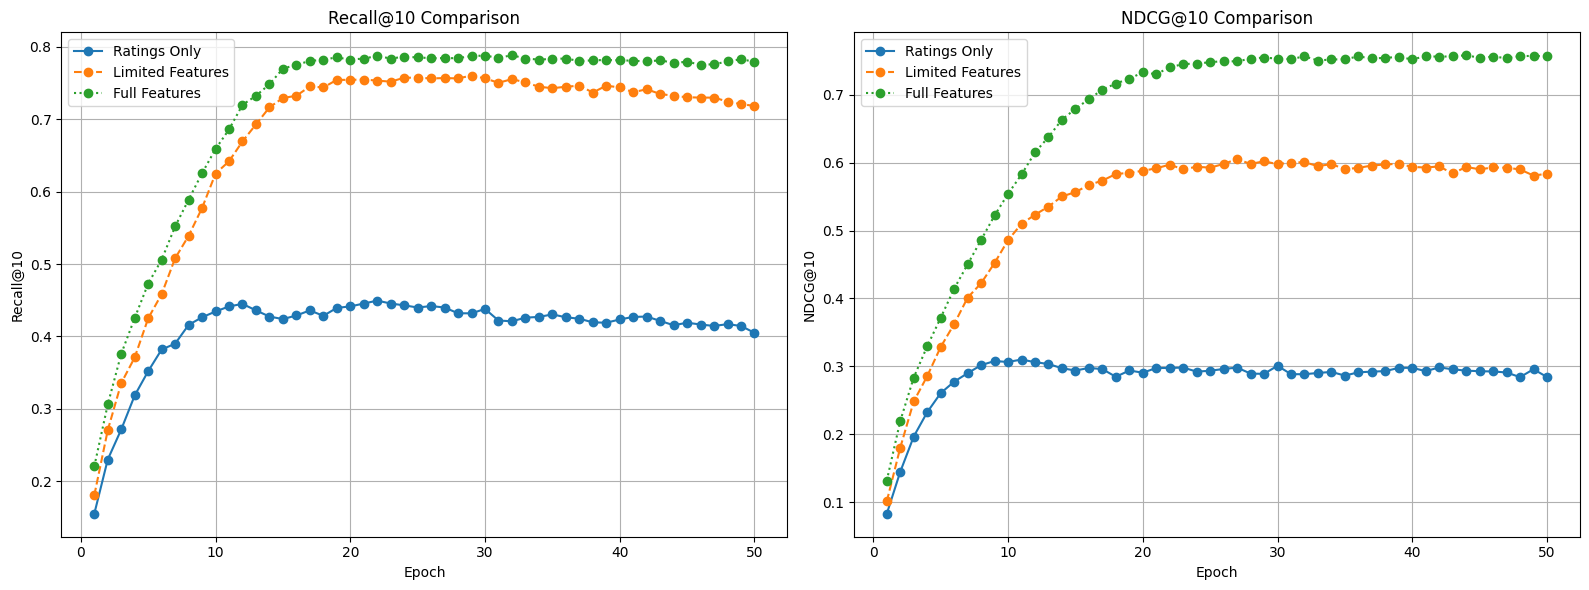

In [16]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange
import copy

# ---------------- Experiment Configurations ----------------
EXPERIMENTS = {
    "Ratings Only": {
        "user_features": [],
        "book_features": []
    },
    "Limited Features": {
        "user_features": ["Age"],
        "book_features": ["genre_cluster"]
    },
    "Full Features": {
        "user_features": ["Age"],
        "book_features": ["genre_cluster", "tone_cluster", "audience_cluster"]
    }
}

# ---------------- Global Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 50
BASE_EMB_DIM = 64
FEATURE_EMB_DIM = 16
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Data Loading & Preprocessing Function (CORRECTED) ────────────
def load_and_preprocess_data(config):
    print(f"Loading data for experiment: {config['name']}...")
    try:
        ratings_raw = pd.read_csv("data/Ratings.csv")
        users_df_raw = pd.read_csv("data/Users.csv")
        books_meta_df_raw = pd.read_csv("clustered_outputs/clustered_books_metadata.csv")
    except FileNotFoundError as e:
        print(f"Error loading data files: {e}")
        return None

    book_cols = ['ISBN'] + config['book_features']
    user_cols = ['User-ID'] + config['user_features']
    books_meta_df = books_meta_df_raw[book_cols]
    users_df = users_df_raw[user_cols]

    if "Age" in users_df.columns:
        users_df['Age'] = users_df['Age'].fillna(users_df['Age'].median()).astype(int)

    df = pd.merge(ratings_raw, users_df, on='User-ID', how='left')
    df = pd.merge(df, books_meta_df, on='ISBN', how='left')
    df = df.dropna(subset=['User-ID', 'ISBN'] + config['user_features'] + config['book_features'])
    df = df[df["Book-Rating"] >= LIKE_TH]

    mappings = {"user_idx": {u: i for i, u in enumerate(df["User-ID"].unique())},
                "book_idx": {b: i for i, b in enumerate(df["ISBN"].unique())}}
    for col in config['user_features'] + config['book_features']:
        mappings[f"{col}_idx"] = {val: i for i, val in enumerate(df[col].unique())}

    # --- THIS IS THE CORRECTED LOGIC ---
    for col, mapping in mappings.items():
        if col == 'user_idx':
            source_col = 'User-ID'
        elif col == 'book_idx':
            source_col = 'ISBN'
        else:
            source_col = col.replace('_idx', '')
        df[col] = df[source_col].map(mapping)
    # ------------------------------------

    df['rank_latest'] = df.groupby('user_idx')['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1].copy()
    test_df = df[df['rank_latest'] == 1].copy()
    
    idx_cols = list(mappings.keys())
    train_df = train_df.dropna(subset=idx_cols).astype({k: int for k in idx_cols})
    test_df = test_df.dropna(subset=idx_cols).astype({k: int for k in idx_cols})
    
    test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)
    sizes = {f"n_{col.replace('_idx', '')}": len(mapping) for col, mapping in mappings.items()}
    
    return train_df, test_df, mappings, sizes

# ─── 3 │ Flexible Dataset and Model ───────────────────────────────────
class NCFDataset(Dataset):
    def __init__(self, df, n_books, config):
        self.df = df
        self.n_books = n_books
        self.config = config
        self.user_item_set = set(zip(df.user_idx.values, df.book_idx.values))
        self.all_feature_cols = ['user_idx', 'book_idx'] + [f"{col}_idx" for col in config['user_features'] + config['book_features']]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        features = {col.replace('_idx',''): row[col] for col in self.all_feature_cols}
        features['item_pos'] = features.pop('book')

        item_neg = np.random.randint(self.n_books)
        while (features['user'], item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
        features['item_neg'] = item_neg
        return features

def collate_fn(batch, config):
    batch_size = len(batch)
    features = {'user': torch.tensor([item['user'] for item in batch], dtype=torch.long).repeat_interleave(2)}
    
    pos_items = torch.tensor([item['item_pos'] for item in batch], dtype=torch.long)
    neg_items = torch.tensor([item['item_neg'] for item in batch], dtype=torch.long)
    features['item'] = torch.stack([pos_items, neg_items], dim=1).flatten()
    
    for col in config['user_features'] + config['book_features']:
        features[col] = torch.tensor([item[col] for item in batch], dtype=torch.long).repeat_interleave(2)
        
    labels = torch.tensor([1, 0] * batch_size, dtype=torch.float32)
    return features, labels

class HybridNCF(nn.Module):
    def __init__(self, sizes, config):
        super().__init__()
        self.config = config
        self.gmf_user_emb = nn.Embedding(sizes['n_user'], BASE_EMB_DIM)
        self.gmf_item_emb = nn.Embedding(sizes['n_book'], BASE_EMB_DIM)
        
        self.mlp_user_emb = nn.Embedding(sizes['n_user'], BASE_EMB_DIM)
        self.mlp_item_emb = nn.Embedding(sizes['n_book'], BASE_EMB_DIM)
        
        self.feature_embeddings = nn.ModuleDict()
        mlp_input_dim = BASE_EMB_DIM * 2
        for col in config['user_features'] + config['book_features']:
            # Correctly reference the size from the 'sizes' dictionary
            size_key = f"n_{col}"
            self.feature_embeddings[col] = nn.Embedding(sizes[size_key], FEATURE_EMB_DIM)
            mlp_input_dim += FEATURE_EMB_DIM
            
        mlp_layers_def = [mlp_input_dim, 256, 128, 64]
        self.mlp = nn.Sequential(*[
            layer for i in range(len(mlp_layers_def) - 1) 
            for layer in (nn.Linear(mlp_layers_def[i], mlp_layers_def[i+1]), nn.ReLU())])
        
        self.predict_layer = nn.Linear(BASE_EMB_DIM + mlp_layers_def[-1], 1)

    def forward(self, features):
        user, item = features['user'], features['item']
        gmf_vector = self.gmf_user_emb(user) * self.gmf_item_emb(item)
        
        mlp_inputs = [self.mlp_user_emb(user), self.mlp_item_emb(item)]
        for col in self.config['user_features'] + self.config['book_features']:
            mlp_inputs.append(self.feature_embeddings[col](features[col]))
            
        mlp_vector = self.mlp(torch.cat(mlp_inputs, dim=-1))
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        return self.predict_layer(final_vector).squeeze()

# ─── 4 │ Flexible Evaluation and Training Loop ────────────────────────
def evaluate(model, test_df, n_books, config, top_k=10, n_neg_samples=100):
    model.eval()
    hits, ndcg_sum, total = 0, 0, 0
    all_book_indices = np.arange(n_books)
    
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            features = {col.replace('_idx', ''): int(row[col]) for col in row.index if '_idx' in col}
            pos_b_idx = features.pop('book')
            
            neg_b_indices = np.random.choice(all_book_indices, n_neg_samples, replace=False)
            eval_b_indices = torch.tensor([pos_b_idx] + list(neg_b_indices), device=DEVICE)
            
            eval_features = {'item': eval_b_indices}
            for col, val in features.items():
                eval_features[col] = torch.tensor([val] * len(eval_b_indices), device=DEVICE)
            
            scores = model(eval_features).cpu().numpy()
            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1
    return (hits / total, ndcg_sum / total) if total else (0, 0)

def run_experiment(config):
    data = load_and_preprocess_data(config)
    if not data: return None
    train_df, test_df, mappings, sizes = data

    train_ds = NCFDataset(train_df, sizes['n_book'], config)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, 
                          collate_fn=lambda batch: collate_fn(batch, config), num_workers=0)

    model = HybridNCF(sizes, config).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.BCEWithLogitsLoss()

    recall_hist, ndcg_hist = [], []
    for epoch in trange(EPOCHS, desc=f"Training '{config['name']}'"):
        model.train()
        for features, labels in train_dl:
            features = {k: v.to(DEVICE) for k, v in features.items()}
            labels = labels.to(DEVICE)
            
            opt.zero_grad()
            predictions = model(features)
            loss = loss_fn(predictions, labels)
            loss.backward()
            opt.step()
            
        recall, ndcg = evaluate(model, test_df, sizes['n_book'], config)
        recall_hist.append(recall)
        ndcg_hist.append(ndcg)
        print(f"Epoch {epoch+1:02d} | {config['name']} | Recall@10: {recall:.4f} | NDCG@10: {ndcg:.4f}")

    return {'recall': recall_hist, 'ndcg': ndcg_hist}

# ─── 5 │ Main Execution and Plotting ──────────────────────────────────
results = {}
for name, config in EXPERIMENTS.items():
    exp_config = copy.deepcopy(config)
    exp_config['name'] = name
    results[name] = run_experiment(exp_config)

plt.figure(figsize=(16, 6))
epochs_range = range(1, EPOCHS + 1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
linestyles = ['-', '--', ':']

plt.subplot(1, 2, 1)
for i, (name, res) in enumerate(results.items()):
    if res:
        plt.plot(epochs_range, res['recall'], marker='o', linestyle=linestyles[i], color=colors[i], label=name)
plt.title("Recall@10 Comparison")
plt.xlabel("Epoch")
plt.ylabel("Recall@10")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, (name, res) in enumerate(results.items()):
    if res:
        plt.plot(epochs_range, res['ndcg'], marker='o', linestyle=linestyles[i], color=colors[i], label=name)
plt.title("NDCG@10 Comparison")
plt.xlabel("Epoch")
plt.ylabel("NDCG@10")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()